In [67]:
import mlflow
import uuid
import pandas as pd
from feast import (
    Entity,
    FeatureStore,
    FeatureService,
    FeatureView,
    Field,
    FileSource
)
from feast.types import Float32, Float64, Int64, String
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from xgboost import XGBRegressor
import dagshub
import joblib
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#problemas con pmdarima
#from pmdarima import auto_arima

In [4]:
import sys
print(sys.executable)



/usr/bin/python3


In [18]:
housepricing = pd.read_csv('../data/ma_lga_12345.csv')
MSTOCK = pd.read_csv('../data/Microsoft_Stock.csv')
housepricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


In [19]:
housepricing
print(housepricing['type'].unique())
#Precio de propiedades indistinto al tipo de vivienda, unidad(depa) o casa

['house' 'unit']


<Axes: xlabel='saledate', ylabel='MA'>

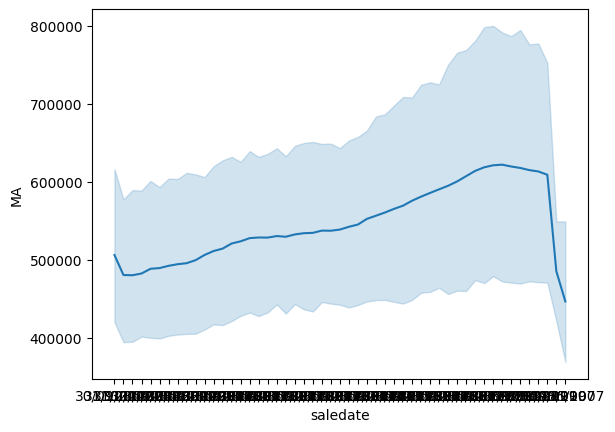

In [20]:
sns.lineplot(x = 'saledate', y = 'MA', data= housepricing)

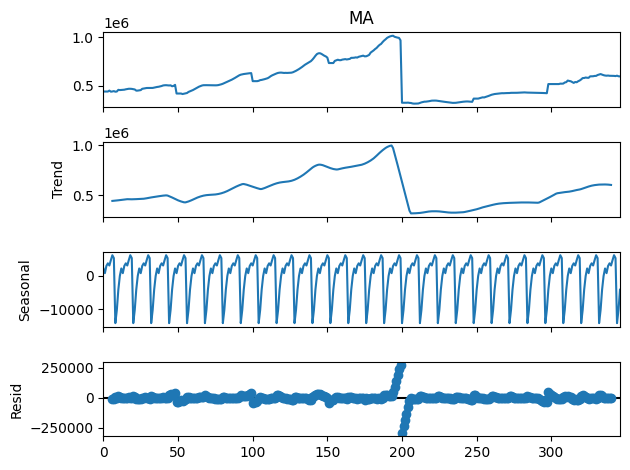

In [30]:
decomposition = seasonal_decompose(
    housepricing['MA'], 
    model='additive', 
    period=12
)
#Seasonig 12 por cierre de año
decomposicion = decomposition.plot()
decomposicion
decomposicion_png = mlflow.log_figure(decomposicion, "decomposicion - housepricing.png")


In [37]:
train_data = housepricing[:int(len(housepricing)*0.80)]
test_data = housepricing[int(len(housepricing)*0.80):]


In [ ]:
mlflow.set_registry_uri("https://dagshub.com/Marquinhos9873/mle2.mlflow")
mlflow.create_experiment('Time series exp. - Housepricing')
mlflow.set_experiment("Time series exp. - Housepricing")

In [73]:
with mlflow.start_run(run_name="TS ensemble") as run:
    train_ensamble_df = train_data.rename(columns={'saledate': 'ds', 'MA': 'y'})
    test_ensamble_df = test_data.rename(columns={'saledate': 'ds', 'MA': 'y'})

    xgboost_ensemble_df = train_ensamble_df.copy()
    xgboost_ensemble_df["LAG1"] = xgboost_ensemble_df['y'].shift(1)
    xgboost_ensemble_df["LAG2"] = xgboost_ensemble_df['y'].shift(2)
    xgboost_ensemble_df["LAG3"] = xgboost_ensemble_df['y'].shift(3)
    xgboost_ensemble_df["LAG4"] = xgboost_ensemble_df['y'].shift(4)

#forecaster = ForecasterAutoreg(
#    regressor = XGBRegressor(objective='reg:squarederror', random_state=123),
#    lags = 12   # usamos 12 meses de rezago porque hay estacionalidad anual
#)
    
    test_xgboost_ensemble_df = test_ensamble_df.copy()
    test_xgboost_ensemble_df["LAG1"] = test_xgboost_ensemble_df['y'].shift(1)
    test_xgboost_ensemble_df["LAG2"] = test_xgboost_ensemble_df['y'].shift(2)
    test_xgboost_ensemble_df["LAG3"] = test_xgboost_ensemble_df['y'].shift(3)
    test_xgboost_ensemble_df["LAG4"] = test_xgboost_ensemble_df['y'].shift(4)


    X_xgboost, y_xgboost = xgboost_ensemble_df.drop(['y', "ds"], axis=1), xgboost_ensemble_df['y']

    #arima = auto_arima(train_ensamble_df['y'], seasonal=True)
    ets = ExponentialSmoothing(train_ensamble_df['y'], trend='add', seasonal='add', seasonal_periods=12).fit()
    #prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
    #prophet.fit(train_ensamble_df)
    xgb = XGBRegressor().fit(X_xgboost, y_xgboost)

    final_ensemble_df = pd.DataFrame(
        {
            #"arima": arima.predict_in_sample(),
            "ets": ets.fittedvalues,
            #"prophet": prophet.predict(train_ensamble_df)["yhat"].values,
            "xgboost": xgb.predict(X_xgboost),
            "exogenous": np.random.normal(size=len(train_ensamble_df)),
            "y" : train_ensamble_df["y"]


        }
    )
    lr = LinearRegression().fit(final_ensemble_df.drop(["y"], axis=1), final_ensemble_df["y"])

    test_final_ensemble_df = pd.DataFrame(
        {
            #"arima": arima.predict(n_periods=len(test_ensamble_df)),
            "ets": ets.forecast(steps=len(test_ensamble_df)),
            #"prophet": prophet.predict(test_ensamble_df)["yhat"].values,
            "xgboost": xgb.predict(test_xgboost_ensemble_df.drop(["ds", "y"], axis=1)),
            "exogenous": np.random.normal(size=len(test_ensamble_df))
        }
    )

    y_pred = lr.predict(test_final_ensemble_df)

    mae = mean_absolute_error(test_ensemble_df['y'], y_pred)
    mse = mean_squared_error(test_ensemble_df['y'], y_pred)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(test_ensemble_df['y'], y_pred)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    

    sns.lineplot(x=train_ensamble_df.index, y=train_ensamble_df['y'],  label='Train')
    sns.lineplot(x=test_final_ensemble_df.index, y=test_ensemble_df['y'], label='Test')
    sns.lineplot(x=test_final_ensemble_df.index, y=lr.predict(test_final_ensemble_df), 
    label='Predicciones basadas en Doordash')
    sns.lineplot(x=test_final_ensemble_df.index, y=(test_final_ensemble_df["ets"]+ test_final_ensemble_df["xgboost"]) / 3
    , label='avg predicton')
    predictions_png = mlflow.log_figure(plt.gcf(), "predictions.png")
    

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:type: object

In [1]:
avg_prediction = (test_final_ensemble_df["ets"] + test_final_ensemble_df["xgboost"]) / 2)

#feature store


#Feature store de avg_prediction hasta el momento con estos datos
#Crear instacias feast

NameError: name 'test_final_ensemble_df' is not defined

In [28]:
MSTOCK

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


<Axes: xlabel='Date', ylabel='Close'>

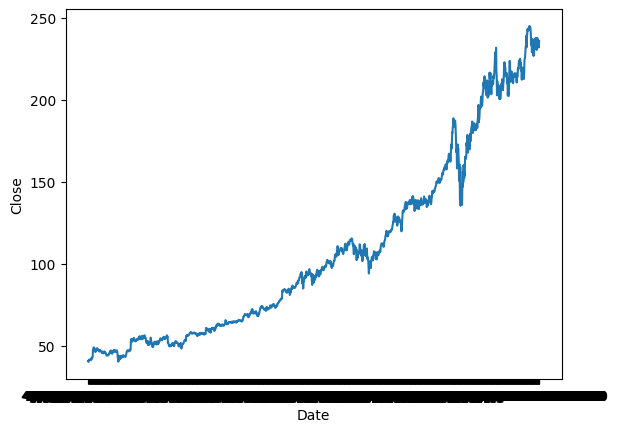

In [29]:
sns.lineplot(x = 'Date', y = 'Close', data= MSTOCK)

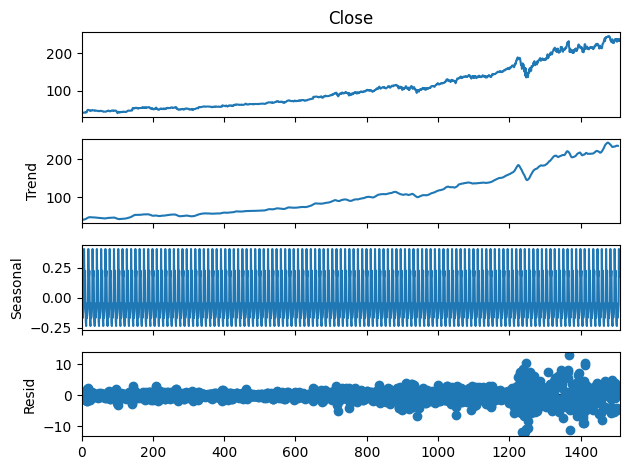

In [33]:
decomposition = seasonal_decompose(
    MSTOCK['Close'], 
    model='adittive', 
    period=12
)

decomposition.plot()
plt.show()

In [ ]:
with mlflow.start_run(run_name="ENSAMBLE v1") as run:

    ensemble_df = train_air_passengers.rename(columns={'Date': 'ds', '#Passengers': 'y'})
    test_ensemble_df = test_air_passengers.rename(columns={'Date': 'ds', '#Passengers': 'y'})


    xgboost_ensemble_df = ensemble_df.copy()
    xgboost_ensemble_df["LAG1"] = xgboost_ensemble_df['y'].shift(1)
    xgboost_ensemble_df["LAG2"] = xgboost_ensemble_df['y'].shift(2)
    xgboost_ensemble_df["LAG3"] = xgboost_ensemble_df['y'].shift(3)
    xgboost_ensemble_df["LAG4"] = xgboost_ensemble_df['y'].shift(4)


    test_xgboost_ensemble_df = test_ensemble_df.copy()
    test_xgboost_ensemble_df["LAG1"] = test_xgboost_ensemble_df['y'].shift(1)
    test_xgboost_ensemble_df["LAG2"] = test_xgboost_ensemble_df['y'].shift(2)
    test_xgboost_ensemble_df["LAG3"] = test_xgboost_ensemble_df['y'].shift(3)
    test_xgboost_ensemble_df["LAG4"] = test_xgboost_ensemble_df['y'].shift(4)



    X_xgboost, y_xgboost = xgboost_ensemble_df.drop(['y', "ds"], axis=1), xgboost_ensemble_df['y']

    arima = auto_arima(ensemble_df['y'], seasonal=True)
    ets = ExponentialSmoothing(ensemble_df['y'], trend='add', seasonal='add', seasonal_periods=12).fit()
    prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
    prophet.fit(ensemble_df)
    xgb = XGBRegressor().fit(X_xgboost, y_xgboost)

    final_ensemble_df = pd.DataFrame(
        {
            "arima": arima.predict_in_sample(),
            "ets": ets.fittedvalues,
            "prophet": prophet.predict(ensemble_df)["yhat"].values,
            "xgboost": xgb.predict(X_xgboost),
            "exogenous": np.random.normal(size=len(ensemble_df)),
            "y" : ensemble_df["y"]


        }
    )
    lr = LinearRegression().fit(final_ensemble_df.drop(["y"], axis=1), final_ensemble_df["y"])

    test_final_ensemble_df = pd.DataFrame(
        {
            "arima": arima.predict(n_periods=len(test_air_passengers)),
            "ets": ets.forecast(steps=len(test_air_passengers)),
            "prophet": prophet.predict(test_ensemble_df)["yhat"].values,
            "xgboost": xgb.predict(test_xgboost_ensemble_df.drop(["ds", "y"], axis=1)),
            "exogenous": np.random.normal(size=len(test_ensemble_df))
        }
    )

    y_pred = lr.predict(test_final_ensemble_df)

    mae = mean_absolute_error(test_ensemble_df['y'], y_pred)
    mse = mean_squared_error(test_ensemble_df['y'], y_pred)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(test_ensemble_df['y'], y_pred)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    

    sns.lineplot(x=ensemble_df.index, y=ensemble_df['y'],  label='Train')
    sns.lineplot(x=test_final_ensemble_df.index, y=test_ensemble_df['y'], label='Test')
    sns.lineplot(x=test_final_ensemble_df.index, y=lr.predict(test_final_ensemble_df), 
    label='Predicciones basadas Doordash')
    sns.lineplot(x=test_final_ensemble_df.index, y=(test_final_ensemble_df["arima"] + test_final_ensemble_df["ets"] + test_final_ensemble_df["prophet"] + test_final_ensemble_df["xgboost"]) / 4
    , label='avg predicton')
    mlflow.log_figure(plt.gcf(), "predictions.png")
    predictions_png = mlflow.log_figure(plt.gcf(), "predictions.png")
    mlflow.log_artifac(predictions_png)

In [ ]:
avg_prediction = (test_final_ensemble_df["arima"] + test_final_ensemble_df["ets"] + test_final_ensemble_df["prophet"] + test_final_ensemble_df["xgboost"]) / 4)
#feature store


In [76]:
train_data_stock = MSTOCK[:int(len(housepricing)*0.80)]
test_data_stock = MSTOCK[int(len(housepricing)*0.80):]

In [75]:
mlflow.set_registry_uri("https://dagshub.com/Marquinhos9873/mle2.mlflow")
mlflow.create_experiment('Time series exp. - Mstock')
mlflow.set_experiment("Time series exp. - Mstock")

<Experiment: artifact_location='file:///home/marquinhoslinux/mle2/notebooks/mlruns/241032245882361631', creation_time=1756082956684, experiment_id='241032245882361631', last_update_time=1756082956684, lifecycle_stage='active', name='Time series exp. - Mstock', tags={}>

In [79]:
with mlflow.start_run(run_name="ENSAMBLE v1") as run:

    ensemble_df = train_data_stock.rename(columns={'Date': 'ds', 'Close': 'y'})
    test_ensemble_df = test_data_stock.rename(columns={'Date': 'ds', 'Close': 'y'})


    xgboost_ensemble_df = ensemble_df.copy()
    xgboost_ensemble_df["LAG1"] = xgboost_ensemble_df['y'].shift(1)
    xgboost_ensemble_df["LAG2"] = xgboost_ensemble_df['y'].shift(2)
    xgboost_ensemble_df["LAG3"] = xgboost_ensemble_df['y'].shift(3)
    xgboost_ensemble_df["LAG4"] = xgboost_ensemble_df['y'].shift(4)


    test_xgboost_ensemble_df = test_ensemble_df.copy()
    test_xgboost_ensemble_df["LAG1"] = test_xgboost_ensemble_df['y'].shift(1)
    test_xgboost_ensemble_df["LAG2"] = test_xgboost_ensemble_df['y'].shift(2)
    test_xgboost_ensemble_df["LAG3"] = test_xgboost_ensemble_df['y'].shift(3)
    test_xgboost_ensemble_df["LAG4"] = test_xgboost_ensemble_df['y'].shift(4)



    X_xgboost, y_xgboost = xgboost_ensemble_df.drop(['y', "ds"], axis=1), xgboost_ensemble_df['y']

    #arima = auto_arima(ensemble_df['y'], seasonal=True)
    ets = ExponentialSmoothing(ensemble_df['y'], trend='add', seasonal='add', seasonal_periods=12).fit()
    prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
    prophet.fit(ensemble_df)
    xgb = XGBRegressor().fit(X_xgboost, y_xgboost)

    final_ensemble_df = pd.DataFrame(
        {
            #"arima": arima.predict_in_sample(),
            "ets": ets.fittedvalues,
            "prophet": prophet.predict(ensemble_df)["yhat"].values,
            "xgboost": xgb.predict(X_xgboost),
            "exogenous": np.random.normal(size=len(ensemble_df)),
            "y" : ensemble_df["y"]


        }
    )
    lr = LinearRegression().fit(final_ensemble_df.drop(["y"], axis=1), final_ensemble_df["y"])

    test_final_ensemble_df = pd.DataFrame(
        {
            #"arima": arima.predict(n_periods=len(test_data_stock)),
            "ets": ets.forecast(steps=len(test_data_stock)),
            "prophet": prophet.predict(test_ensemble_df)["yhat"].values,
            "xgboost": xgb.predict(test_xgboost_ensemble_df.drop(["ds", "y"], axis=1)),
            "exogenous": np.random.normal(size=len(test_ensemble_df))
        }
    )

    y_pred = lr.predict(test_final_ensemble_df)

    mae = mean_absolute_error(test_ensemble_df['y'], y_pred)
    mse = mean_squared_error(test_ensemble_df['y'], y_pred)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(test_ensemble_df['y'], y_pred)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAPE", mape)
    

    sns.lineplot(x=ensemble_df.index, y=ensemble_df['y'],  label='Train')
    sns.lineplot(x=test_final_ensemble_df.index, y=test_ensemble_df['y'], label='Test')
    sns.lineplot(x=test_final_ensemble_df.index, y=lr.predict(test_final_ensemble_df), 
    label='Predicciones basadas Doordash')
    sns.lineplot(x=test_final_ensemble_df.index, y=(test_final_ensemble_df["ets"] + test_final_ensemble_df["prophet"] + test_final_ensemble_df["xgboost"]) / 4
    , label='avg predicton')
    mlflow.log_figure(plt.gcf(), "predictions.png")
    predictions_png = mlflow.log_figure(plt.gcf(), "predictions.png")
    mlflow.log_artifac(predictions_png)

19:53:42 - cmdstanpy - INFO - Chain [1] start processing
19:53:42 - cmdstanpy - INFO - Chain [1] done processing
19:53:42 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 11 Unknown error -11
Optimization terminated abnormally. Falling back to Newton.
19:53:42 - cmdstanpy - INFO - Chain [1] start processing
19:53:42 - cmdstanpy - INFO - Chain [1] done processing
19:53:42 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 11 Unknown error -11


RuntimeError: Error during optimization! Command '/home/marquinhoslinux/.local/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin random seed=86793 data file=/tmp/tmpbq9tow5_/3fq1fn_o.json init=/tmp/tmpbq9tow5_/xah4a823.json output file=/tmp/tmpbq9tow5_/prophet_model_ejd1n43/prophet_model-20250824195342.csv method=optimize algorithm=newton iter=10000' failed: 